In [5]:
import numpy as np
import random as rand


# Deutsch-Jozsa

In [6]:
def dj_oracle(n):
    '''
    Input: o tamanho do registro de input n
    Output: Uma matriz aleatória unitária U e uma string

    Escolhe aleatoriamente se a função é constante ou equilibrada.
    Se for constante escolhe aleatoriamente se é do tipo f(x) = 0 ou f(x) = 1
    Se for equilibrada escolhe N/2 índices aleatórios sem reposição

    Quando é f(x) = 1 multiplica-se a matriz identidade por -1 ((-1)^f(x) == -1)
    Quando é equilibrada multiplicam-se por -1 os índices da matriz identidade escolhidos
    '''

    N = 2 ** n

    indexes = list(np.arange(N))

    U = np.identity(N)

    type = rand.choice(["constant", "balanced"])

    if type == "constant":

        type = rand.choice(["f(x)=0", "f(x)=1"])

        if type == "f(x)=1":

            U = U * -1
    
    if type == "balanced":
        
        for i in range(int(N/2)):
            ind=rand.choice(indexes)
            U[ind][ind] = -1
            indexes.remove(ind)
    
    return U, type

In [7]:
from qiskit import QuantumCircuit

def dj_algorithm(oracle):
    '''
    Input: O oráculo U_f
    Output: O circuito quântico dj

    Segue os passos
    '''

    n = int(np.log2(np.size(oracle[0])))

    dj = QuantumCircuit(n + 1, n)

    # Hadamard nos bits input
    for i in range(n):
        dj.h(i)

    # |0> -> |1> -> |->
    dj.x(n)
    dj.h(n)
    
    # Oráculo
    dj.unitary(oracle, range(n))

    for i in range(n):
        dj.h(i)
    
    for i in range(n):
        dj.measure(i,i)
    
    return dj

In [8]:
from qiskit import transpile, Aer
simulator = Aer.get_backend('qasm_simulator')

f(x)=1


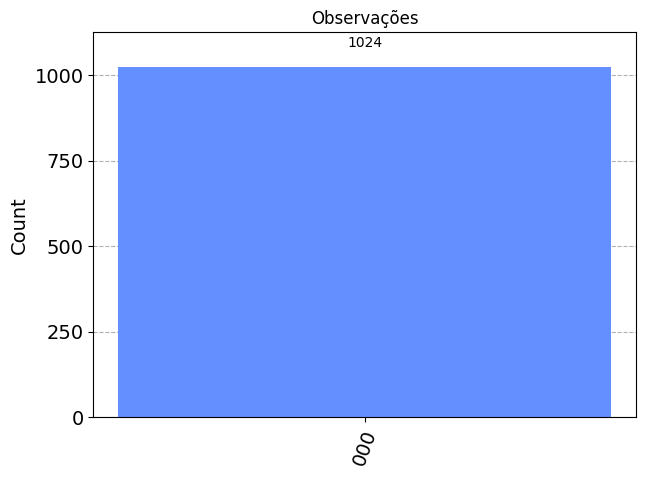

In [9]:
from qiskit.visualization import plot_histogram
U, type = dj_oracle(3)     
print(type)
dj = dj_algorithm(U)

circ = transpile(dj, simulator)
result = simulator.run(circ, shots=1024).result()
counts = result.get_counts(circ)

plot_histogram(counts, title='Observações')

# Grover

In [10]:
def g_oracle(N, M = 'r'):
    '''
    Input: Tamanho da lista e número de soluções. Se for desconhecido escolhemos aleatoriamente
    Output: O oráculo e o número de iterações ideal

    '''

    solutions = []

    if M == 'r':
        M = rand.randint(1, N)
        N = 2 * N
    
    elif M >= N / 2:
        N = 2 * N

    n = int(np.ceil(np.log2(N)))

    indexes = list(range(N))
    
    # M soluções aleatórias
    for i in range(M):
        ind = rand.choice(indexes)
        solutions.append(ind)
        indexes.remove(ind)
    
    bin_sol = []
    for sol in solutions:
        bin_sol.append('{0:b}'.format(sol))
    print(np.sort(bin_sol))
    
    U = np.identity(2 ** n)
    for ind in solutions:
            U[ind][ind] = U[ind][ind] * -1

    iter = int(np.floor((np.pi / 4) * np.sqrt(N/M)) )        
    
    return U, iter

In [11]:
def G(n, oracle):

    qc = QuantumCircuit(n)

    dim = 2 ** n

    uni_sup = np.ones((1, dim)) * (1 / (np.sqrt(dim)))

    G = np.matmul((2 * np.kron(np.transpose(uni_sup), uni_sup) - np.identity(dim)), oracle)

    qc.unitary(G, range(n))

    G_gate = qc.to_gate()
    G_gate.name = "G"

    return G_gate


In [12]:

def grover(oracle):

    n = int(np.log2(np.size(oracle[0])))

    qc = QuantumCircuit(n)

    for qubit in range(n):
        qc.h(qubit)

    for i in range(ITER):
        qc.append(G(n, oracle), range(n))
    
    qc.measure_all()
    return qc

In [38]:
oracle, ITER = g_oracle(4,3)
grover_qc = grover(oracle)


['0' '110' '111']


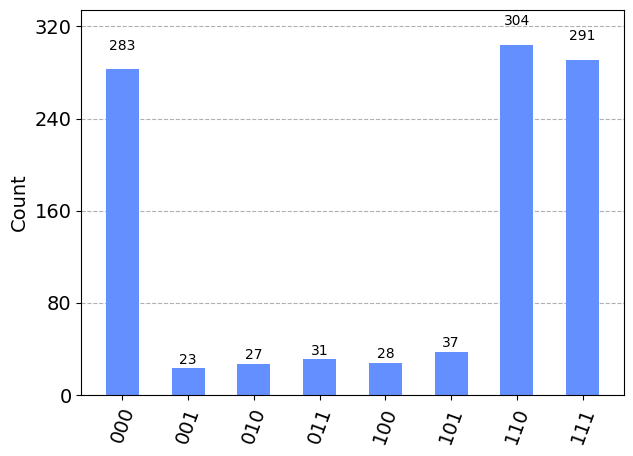

In [39]:

transpiled_grover_circuit = transpile(grover_qc, simulator)
results = simulator.run(transpiled_grover_circuit, shots=1024).result()
counts = results.get_counts()
plot_histogram(counts)